In [10]:

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
import torch
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from PIL import Image
import numpy as np
import cv2

In [11]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


### 1. Insert Saved *.pt Model here:

In [12]:
# pickle does not save the model class itself. Rather, it saves a path to the file containing the class, which is used during load time
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 5)
        # Fully connected layer matched on output of conv2 layer
        # (64-5+1 = 60/2(pool) = 30-5+1 = 26/2 = 13)
        # (128-5+1 = 124/2(pool) = 62-5+1 = 58/2 = 29)
        # (224-5+1)= 220/2 = 110-5+1 = 106/2 = 53
        self.fc1 = nn.Linear(16 * 53 * 53, 256)
        
        # https://pure.tudelft.nl/ws/portalfiles/portal/72959187/1_s2.0_S1755534518300058_main.pdf
        # Based on our analyses we advise to use a minimum sample size of fifty times the number of weights in the neural network
        # but we only have 300 or so samples 300/50 = 6 weights xD
        # 2/3 * amount of input neurons in this case it would be: 2/3*224 = 150 neurons (lets take 128+32 = 160)
        # 2 hiddnelayers for discontinuous as network topology

        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)
        self.drop1 = nn.Dropout(dropout)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 16 * 53 * 53)

        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))

        # No activation on final layer
        return self.fc3(x)
    
model = torch.load('apple_myCNN_classifier.pt', map_location=device)

In [13]:
model.eval()

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)

### 2. Insert image location of the apple:

In [14]:
image_url = 'myapple_2.jpg'
img = cv2.imread(image_url)

In [15]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Switch from BGR to RGB
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


In [16]:
# Move the input tensor to the same device as the model
input_tensor = input_tensor.to(device)

# Ensure that the model's weight tensor is on the same device as the input tensor
model.to(device)
model.eval()


CNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)

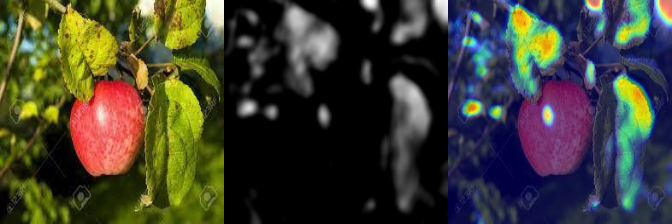

In [18]:
target_layers = [model.conv2]


targets = [ClassifierOutputTarget(3)]


with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)